# Image Classification with Logistic Regression

In [1]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

<IPython.core.display.Javascript object>

In [2]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10

## Dataset & Data loaders

In [3]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

100%|██████████| 9912422/9912422 [00:00<00:00, 41068190.55it/s]


Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 29000644.92it/s]


Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31192567.95it/s]


Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4501542.71it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



Label: 6


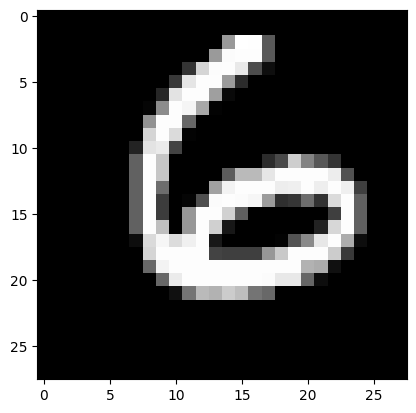

In [4]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

## Model

In [5]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

# Training

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [8]:
evaluate(model, val_loader)

{'val_loss': 2.3026506900787354, 'val_acc': 0.12763671576976776}

In [9]:
history = fit(10, 0.002, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6703, val_acc: 0.7253
Epoch [1], val_loss: 1.3214, val_acc: 0.7758
Epoch [2], val_loss: 1.1151, val_acc: 0.8015
Epoch [3], val_loss: 0.9824, val_acc: 0.8143
Epoch [4], val_loss: 0.8905, val_acc: 0.8277
Epoch [5], val_loss: 0.8231, val_acc: 0.8352
Epoch [6], val_loss: 0.7713, val_acc: 0.8397
Epoch [7], val_loss: 0.7304, val_acc: 0.8449
Epoch [8], val_loss: 0.6969, val_acc: 0.8479
Epoch [9], val_loss: 0.6691, val_acc: 0.8508


Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

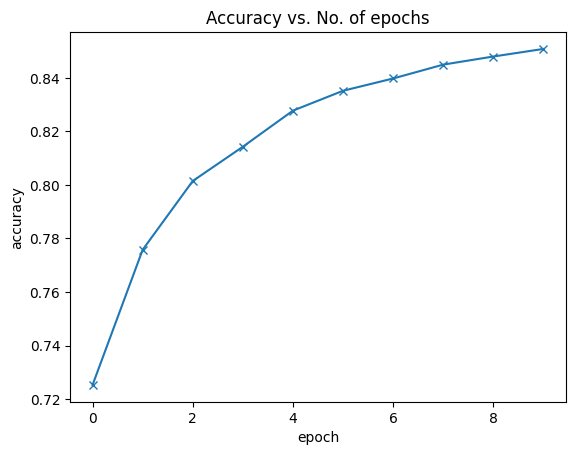

In [10]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

In [11]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.6434162855148315, 'val_acc': 0.8583984375}

## Prediction

In [12]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 6


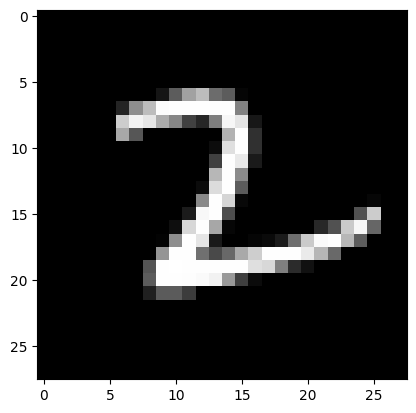

In [13]:
img, label = test_ds[919]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))